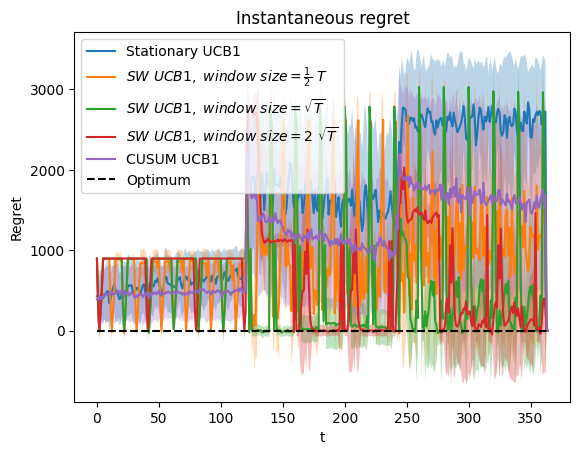

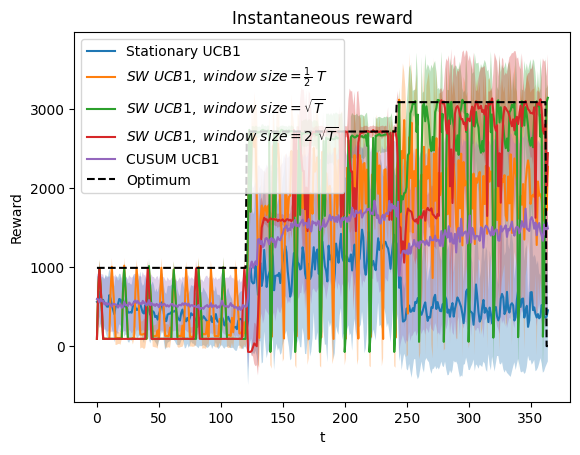

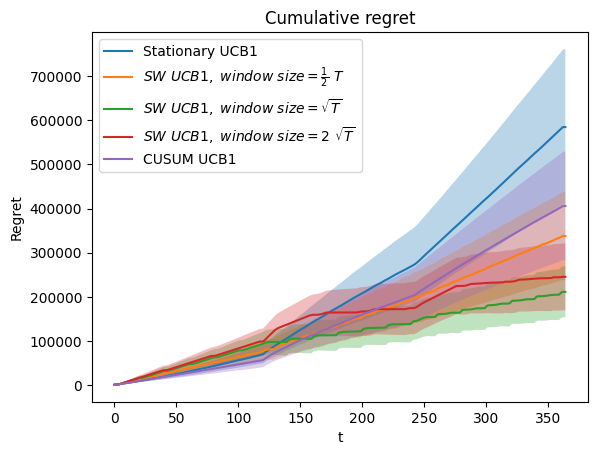

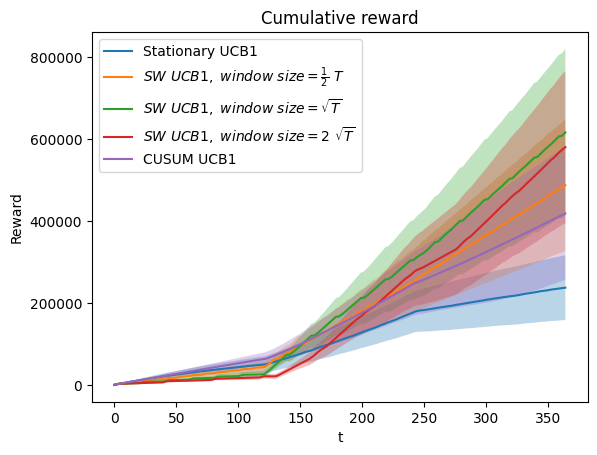

In [3]:
#%%
from Customer import *
from UserClass import *
from UCB1_Learner import *
from Non_Stationary_Environment import *
from SWUCB_Learner import *
from CDUCB_Learner import *
from plotResults import Plotter
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt, log



customers = []

customers.append(Customer('C1', -1.5, 0.1, 100, [0.95,0.70,0.53,0.28,0.14]))
customers.append(Customer('C2', -0.5, -1.5, 80,[0.8,0.78,0.63,0.48,0.3]))
customers.append(Customer('C3', -5, 0.3, 65,[0.7,0.6,0.41,0.22,0.1]))

c1 = UserClass(
    np.array([10, 20, 30, 40, 50]),
    np.array([
        [0.95, 0.70, 0.53, 0.28, 0.14],
        [0.05, 0.25, 0.83, 0.95, 0.45],
        [0.75, 0.64, 0.06, 0.62, 0.82]
    ])
)

prb = (c1.prices - 8) * c1.probabilities
best_gain = prb.max(axis=1)

clicks = int(customers[0].num_clicks(2))
cost = customers[0].cum_cost_clicks(2)
margin = c1.prices - 8
rewards = (margin * c1.probabilities - cost) * clicks

n_arms = len(c1.prices)

T = 365
n_experiments = 50
n_phases = 3
phases_len = int(T / n_phases)


"""
SENSITIVITY ANALYSIS CUSUM
w_sizes = [int(0.5 * sqrt(T)), int(sqrt(T)), int(2 * sqrt(T)), int(4 * sqrt(T)), int(6 * sqrt(T))]
eps_params = [0.1, 0.25, 0.5, 0.75, 1]
h_params = [0.5 * log(T), log(T), 2 * log(T), 4 * log(T), 6 * log(T)]
alpha_params = []
"""

# window_size
M = 100

# exploration term
eps = 0.1

# detection threshold
h = 2 * np.log(T)

# scaling
alpha = 0.01

ucb1_rewards_per_experiment = []
swucb_w1_rewards_per_experiment = []
swucb_w2_rewards_per_experiment = []
swucb_w3_rewards_per_experiment = []
cducb_rewards_per_experiment = []

for e in range(0, n_experiments):
    ucb1_env = Non_Stationary_Environment(c1.probabilities, T, n_phases)
    swucb_w1_env = Non_Stationary_Environment(c1.probabilities, T, n_phases)
    swucb_w2_env = Non_Stationary_Environment(c1.probabilities, T, n_phases)
    swucb_w3_env = Non_Stationary_Environment(c1.probabilities, T, n_phases)
    cducb_env = Non_Stationary_Environment(c1.probabilities, T, n_phases)

    ucb1_learner = UCB1_Learner(n_arms, c1.prices, margin, clicks, cost)
    swucb_learner_w1 = SWUCB_Learner(n_arms, c1.prices, int(0.5 * sqrt(T)), margin, clicks, cost)
    swucb_learner_w2 = SWUCB_Learner(n_arms, c1.prices, int(sqrt(T)), margin, clicks, cost)
    swucb_learner_w3 = SWUCB_Learner(n_arms, c1.prices, int(2 * sqrt(T)), margin, clicks, cost)
    cducb_learner = CDUCB_Learner(n_arms, c1.prices, M, eps, h, alpha, margin, clicks, cost)

    for t in range(0, T):
        # UCB1
        pulled_arm = ucb1_learner.pull_arm()
        reward = ucb1_env.round(pulled_arm, clicks)
        ucb1_learner.update(pulled_arm, reward)

        # SWUCB1 window size = 0.5 * T
        pulled_arm = swucb_learner_w1.pull_arm()
        reward = swucb_w1_env.round(pulled_arm, clicks)
        swucb_learner_w1.update(pulled_arm, reward)

        # SWUCB1 window size = sqrt(T)
        pulled_arm = swucb_learner_w2.pull_arm()        
        reward = swucb_w2_env.round(pulled_arm, clicks)
        swucb_learner_w2.update(pulled_arm, reward)

        # SWUCB1 window size = 2 * sqrt(T)
        pulled_arm = swucb_learner_w3.pull_arm()
        reward = swucb_w3_env.round(pulled_arm, clicks)
        swucb_learner_w3.update(pulled_arm, reward)

        # CUSUM UCB
        pulled_arm = cducb_learner.pull_arm()
        reward = cducb_env.round(pulled_arm, clicks)
        cducb_learner.update(pulled_arm, reward)

    ucb1_rewards_per_experiment.append(ucb1_learner.collected_rewards)
    swucb_w1_rewards_per_experiment.append(swucb_learner_w1.collected_rewards)
    swucb_w2_rewards_per_experiment.append(swucb_learner_w2.collected_rewards)
    swucb_w3_rewards_per_experiment.append(swucb_learner_w3.collected_rewards)
    cducb_rewards_per_experiment.append(cducb_learner.collected_rewards)

ucb1_rewards_per_experiment = np.array(ucb1_rewards_per_experiment)
swucb_w1_rewards_per_experiment = np.array(swucb_w1_rewards_per_experiment)
swucb_w2_rewards_per_experiment = np.array(swucb_w2_rewards_per_experiment)
swucb_w3_rewards_per_experiment = np.array(swucb_w3_rewards_per_experiment)
cducb_rewards_per_experiment = np.array(cducb_rewards_per_experiment)

ucb1_regret = np.zeros(T)
swucb_w1_regret = np.zeros(T)
swucb_w2_regret = np.zeros(T)
swucb_w3_regret = np.zeros(T)
cducb_regret = np.zeros(T)

ucb1_std_regret = np.zeros(T)
swucb_w1_std_regret = np.zeros(T)
swucb_w2_std_regret = np.zeros(T)
swucb_w3_std_regret = np.zeros(T)
cducb_std_regret = np.zeros(T)

opt_per_phase = rewards.max(axis=1)
optimum_per_round = np.zeros(T)

for i in range(n_phases):
    t_index = range(i * phases_len, (i + 1) * phases_len)
    optimum_per_round[t_index] = opt_per_phase[i]

    # Regret
    ucb1_regret[t_index] = np.mean(opt_per_phase[i] - ucb1_rewards_per_experiment, axis=0)[t_index]
    swucb_w1_regret[t_index] = np.mean(opt_per_phase[i] - swucb_w1_rewards_per_experiment, axis=0)[t_index]
    swucb_w2_regret[t_index] = np.mean(opt_per_phase[i] - swucb_w2_rewards_per_experiment, axis=0)[t_index]
    swucb_w3_regret[t_index] = np.mean(opt_per_phase[i] - swucb_w3_rewards_per_experiment, axis=0)[t_index]
    cducb_regret[t_index] = np.mean(opt_per_phase[i] - cducb_rewards_per_experiment, axis=0)[t_index]

    # Standard deviation instantaneous regret
    ucb1_std_regret[t_index] = np.std(opt_per_phase[i] - ucb1_rewards_per_experiment, axis=0)[t_index]
    swucb_w1_std_regret[t_index] = np.std(opt_per_phase[i] - swucb_w1_rewards_per_experiment, axis=0)[t_index]
    swucb_w2_std_regret[t_index] = np.std(opt_per_phase[i] - swucb_w2_rewards_per_experiment, axis=0)[t_index]
    swucb_w3_std_regret[t_index] = np.std(opt_per_phase[i] - swucb_w3_rewards_per_experiment, axis=0)[t_index]
    cducb_std_regret[t_index] = np.std(opt_per_phase[i] - cducb_rewards_per_experiment, axis=0)[t_index]

# Instantaneous reward
ucb1_inst_reward = np.mean(ucb1_rewards_per_experiment, axis=0)
swucb_w1_inst_reward = np.mean(swucb_w1_rewards_per_experiment, axis=0)
swucb_w2_inst_reward = np.mean(swucb_w2_rewards_per_experiment, axis=0)
swucb_w3_inst_reward = np.mean(swucb_w3_rewards_per_experiment, axis=0)
cducb_inst_reward = np.mean(cducb_rewards_per_experiment, axis=0)

# Cumulative regret
ucb1_cum_regret = np.cumsum(ucb1_regret)
swucb_w1_cum_regret = np.cumsum(swucb_w1_regret)
swucb_w2_cum_regret = np.cumsum(swucb_w2_regret)
swucb_w3_cum_regret = np.cumsum(swucb_w3_regret)
cducb_cum_regret = np.cumsum(cducb_regret)

# Cumulative reward
ucb1_cum_reward = np.cumsum(np.mean(ucb1_rewards_per_experiment, axis=0))
swucb_w1_cum_reward = np.cumsum(np.mean(swucb_w1_rewards_per_experiment, axis=0))
swucb_w2_cum_reward = np.cumsum(np.mean(swucb_w2_rewards_per_experiment, axis=0))
swucb_w3_cum_reward = np.cumsum(np.mean(swucb_w3_rewards_per_experiment, axis=0))
cducb_cum_reward = np.cumsum(np.mean(cducb_rewards_per_experiment, axis=0))

# Standard deviation cumulative regret
ucb1_cumstd_regret = [(np.cumsum(ucb1_regret))[:i].std() for i in range(1, T + 1)]
swucb_w1_cumstd_regret = [(np.cumsum(swucb_w1_regret))[:i].std() for i in range(1, T + 1)]
swucb_w2_cumstd_regret = [(np.cumsum(swucb_w2_regret))[:i].std() for i in range(1, T + 1)]
swucb_w3_cumstd_regret = [(np.cumsum(swucb_w3_regret))[:i].std() for i in range(1, T + 1)]
cducb_cumstd_regret = [(np.cumsum(cducb_regret))[:i].std() for i in range(1, T + 1)]

# Standard deviation instantaneous reward
ucb1_std_reward = np.std(ucb1_rewards_per_experiment, axis=0)
swucb_w1_std_reward = np.std(swucb_w1_rewards_per_experiment, axis=0)
swucb_w2_std_reward = np.std(swucb_w2_rewards_per_experiment, axis=0)
swucb_w3_std_reward = np.std(swucb_w3_rewards_per_experiment, axis=0)
cducb_std_reward = np.std(cducb_rewards_per_experiment, axis=0)

# Standard deviation cumulative reward
ucb1_cumstd_reward = [(np.cumsum(ucb1_rewards_per_experiment))[:i].std() for i in range(1, T + 1)]
swucb_w1_cumstd_reward = [(np.cumsum(swucb_w1_rewards_per_experiment))[:i].std() for i in range(1, T + 1)]
swucb_w2_cumstd_reward = [(np.cumsum(swucb_w2_rewards_per_experiment))[:i].std() for i in range(1, T + 1)]
swucb_w3_cumstd_reward = [(np.cumsum(swucb_w3_rewards_per_experiment))[:i].std() for i in range(1, T + 1)]
cducb_cumstd_reward = [(np.cumsum(cducb_rewards_per_experiment))[:i].std() for i in range(1, T + 1)]

#%%
dataset = np.array([
    [
        [ucb1_regret, ucb1_std_regret],
        [ucb1_inst_reward, ucb1_std_reward], 
        [ucb1_cum_regret, ucb1_cumstd_regret], 
        [ucb1_cum_reward, ucb1_cumstd_reward]
    ],
    [
        [swucb_w1_regret, swucb_w1_std_regret],
        [swucb_w1_inst_reward, swucb_w1_std_reward], 
        [swucb_w1_cum_regret, swucb_w1_cumstd_regret], 
        [swucb_w1_cum_reward, swucb_w1_cumstd_reward]
    ],
    [
        [swucb_w2_regret, swucb_w2_std_regret],
        [swucb_w2_inst_reward, swucb_w2_std_reward], 
        [swucb_w2_cum_regret, swucb_w2_cumstd_regret], 
        [swucb_w2_cum_reward, swucb_w2_cumstd_reward]
    ],
    [
        [swucb_w3_regret, swucb_w3_std_regret],
        [swucb_w3_inst_reward, swucb_w3_std_reward], 
        [swucb_w3_cum_regret, swucb_w3_cumstd_regret], 
        [swucb_w3_cum_reward, swucb_w3_cumstd_reward]
    ],
    [
        [cducb_regret, cducb_std_regret],
        [cducb_inst_reward, cducb_std_reward], 
        [cducb_cum_regret, cducb_cumstd_regret], 
        [cducb_cum_reward, cducb_cumstd_reward]
    ]
])

titles = ["Instantaneous regret", "Instantaneous reward", "Cumulative regret", "Cumulative reward"]

ucb1_label = "Stationary UCB1"
swucb_w1_label = r"$SW\ UCB1,\ window\ size=\frac{1}{2}\ T$"
swucb_w2_label = r"$SW\ UCB1,\ window\ size=\sqrt{T}$"
swucb_w3_label = r"$SW\ UCB1,\ window\ size=2\ \sqrt{T}$"
cducb_label = "CUSUM UCB1"
labels = [ucb1_label, swucb_w1_label, swucb_w2_label, swucb_w3_label, cducb_label]

plotter = Plotter(dataset, optimum_per_round, titles, labels, T)
plotter.plots()